In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [2]:
df = pd.read_csv('laptops.csv')

In [3]:
df.shape

(2160, 12)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

### EDA

* Look at the `final_price` variable. Does it have a long tail? 

In [5]:
df = df.loc[:, ['ram', 'storage', 'screen', 'final_price']]

In [6]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


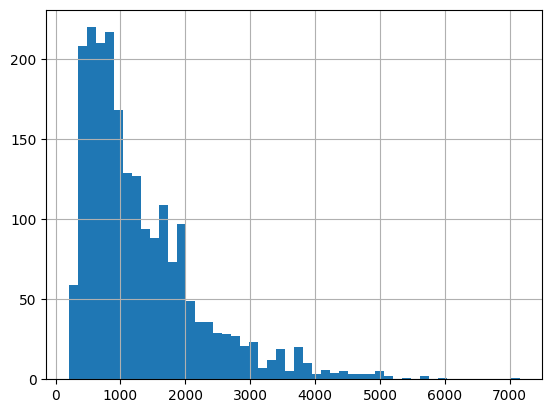

In [8]:
df.final_price.hist(bins=50);

### Question 1

There's one column with missing values. What is it?

* `'ram'`
* `'storage'`
* **`'screen'`**
* `'final_price'`


In [9]:
df.isnull().any().eq(True).sum()

np.int64(1)

In [10]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2

What's the median (50% percentile) for variable `'ram'`?

- 8
- **16**
- 24
- 32

In [10]:
df.ram.median()

np.float64(16.0)

In [11]:
df.ram.describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [11]:
idx = np.arange(df.shape[0])
np.random.seed(42)
np.random.shuffle(idx)

In [12]:
n_val = int(df.shape[0] * 0.2)
n_test = int(df.shape[0] * 0.2)
n_train = df.shape[0] - n_val - n_test

In [13]:
n_train, n_val, n_test

(1296, 432, 432)

In [14]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [15]:
df_train.head(5)

,ram,storage,screen,final_price
2079,32,1000,15.6,1123.29
668,4,64,14.1,201.05
2073,32,1000,14.0,997.74
1113,16,512,13.3,1016.00
788,32,1000,16.0,2739.00


In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [18]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [19]:
df_test.head(5)

,ram,storage,screen
0,32,1000,15.6
1,16,512,13.0
2,16,512,15.6
3,16,512,15.0
4,16,1000,15.6


### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- **With 0**
- With mean
- Both are equally good

In [20]:
df_train.isnull().sum()

ram        0
storage    0
screen     3
dtype: int64

### Data with 0 in null values for the screen column

In [21]:
X_train_zero = df_train.fillna(0)
X_val_zero = df_val.fillna(0)
X_test_zero = df_test.fillna(0)

### Data with mean in null values for the screen column

In [22]:
screen_mean = df_train.screen.mean()

In [23]:
X_train_mean = df_train.fillna(screen_mean)
X_val_mean = df_val.fillna(screen_mean)
X_test_mean = df_test.fillna(screen_mean)

In [38]:
y_train

array([1123.29,  201.05,  997.74, ..., 1059.  , 1671.  , 1056.  ])

### RMSE and Linear Regression functions

In [24]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

### Linear Regression with 0 as a fill NA value

In [25]:
w0, w = train_linear_regression(X_train_zero, y_train)

y_pred_zero = w0 + X_val_zero.dot(w)

In [35]:
score = round(rmse(y_val, y_pred_zero), 2)
score

np.float64(597.36)

<Axes: ylabel='Count'>

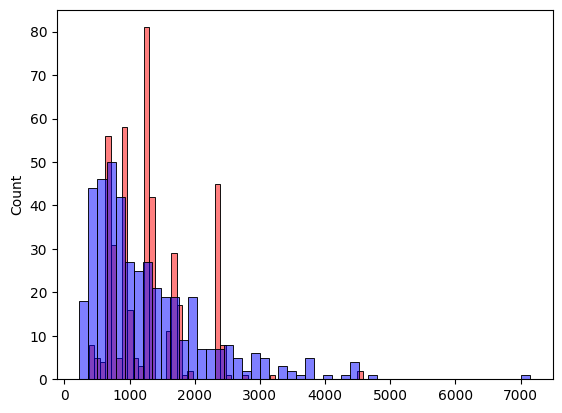

In [30]:
sns.histplot(y_pred_zero, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

In [27]:
w0, w = train_linear_regression(X_train_mean, y_train)

y_pred_mean = w0 + X_val_mean.dot(w)

In [28]:
round(rmse(y_val, y_pred_mean), 2)

np.float64(600.27)

<Axes: ylabel='Count'>

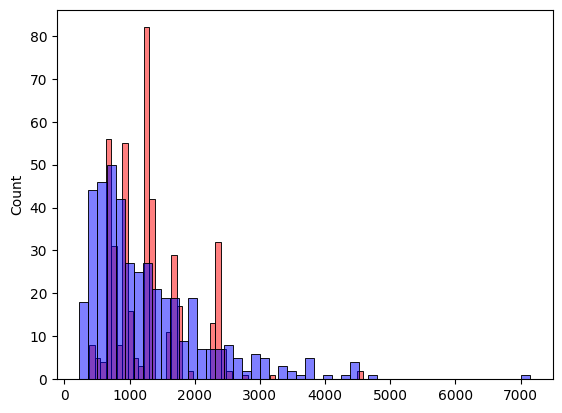

In [31]:
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- **10**
- 100

In [40]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [41]:
r = [0, 0.01, 0.1, 1, 5, 10, 100]

In [42]:
for i in r:
    w0, w = train_linear_regression_reg(X_train_zero, y_train, r=i)

    y_pred_zero = w0 + X_val_zero.dot(w)
    print(f'RMSE for value {i} and w = {w0} = > {rmse(y_val, y_pred_zero)}')


RMSE for value 0 and w = 676.8954853003995 = > 597.3635593619622
RMSE for value 0.01 and w = 676.2736817205587 = > 597.3616819856013
RMSE for value 0.1 and w = 670.7284836314063 = > 597.345159296362
RMSE for value 1 and w = 619.9030834108207 = > 597.2121215589519
RMSE for value 5 and w = 463.7771697142356 = > 597.0111186297033
RMSE for value 10 and w = 352.79713367679835 = > 597.0587680661115
RMSE for value 100 and w = 66.92071440181994 = > 597.9032640603043


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- **29.176**
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [43]:
std_list = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Seed to shuffle the data
    idx = np.arange(df.shape[0])
    np.random.seed(seed=seed)
    np.random.shuffle(idx)

    # Split the data
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train: n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    # Reset the index of the new data
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Get the dependent variable separate and delete it from the main data
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_train = df_train.fillna(0)
    X_val = df_val.fillna(0)
    X_test = df_test.fillna(0)

    # Run Linear Regresion
    w0, w = train_linear_regression(X_train, y_train)

    y_pred = w0 + X_val.dot(w)

    std_list.append(rmse(y_val, y_pred))

In [44]:
round(np.std(std_list), 3)

np.float64(29.176)

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- **598.60**
- 608.60
- 618.60
- 628.60

In [45]:
idx = np.arange(df.shape[0])
np.random.seed(seed=9)
np.random.shuffle(idx)

# Split the data
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]


df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

# Get the dependent variable separate and delete it from the main data
y_full_train = df_full_train.final_price.values
del df_full_train['final_price']

X_full_train = df_full_train.fillna(0)

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

y_pred = w0 + X_full_train.dot(w)
print(f'RMSE for value {0.001} and w = {w0} = > {rmse(y_full_train, y_pred)}')

RMSE for value 0.001 and w = 698.4247442538174 = > 586.1916732996197
